<a href="https://colab.research.google.com/github/jazz9832/facial-detection-and-music-suggestion/blob/main/facial_detection_and_music_suggestion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import cv2
import os
import random
from skimage.io import imread
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D,MaxPooling2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from IPython.display import Audio

In [ ]:
print("TensorFlow version :", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version : 2.12.0
Num GPUs Available:  1


In [ ]:
import zipfile


In [ ]:
zip_file = zipfile.ZipFile('/content/archive.zip', 'r')

In [ ]:
zip_file.extractall('/content')

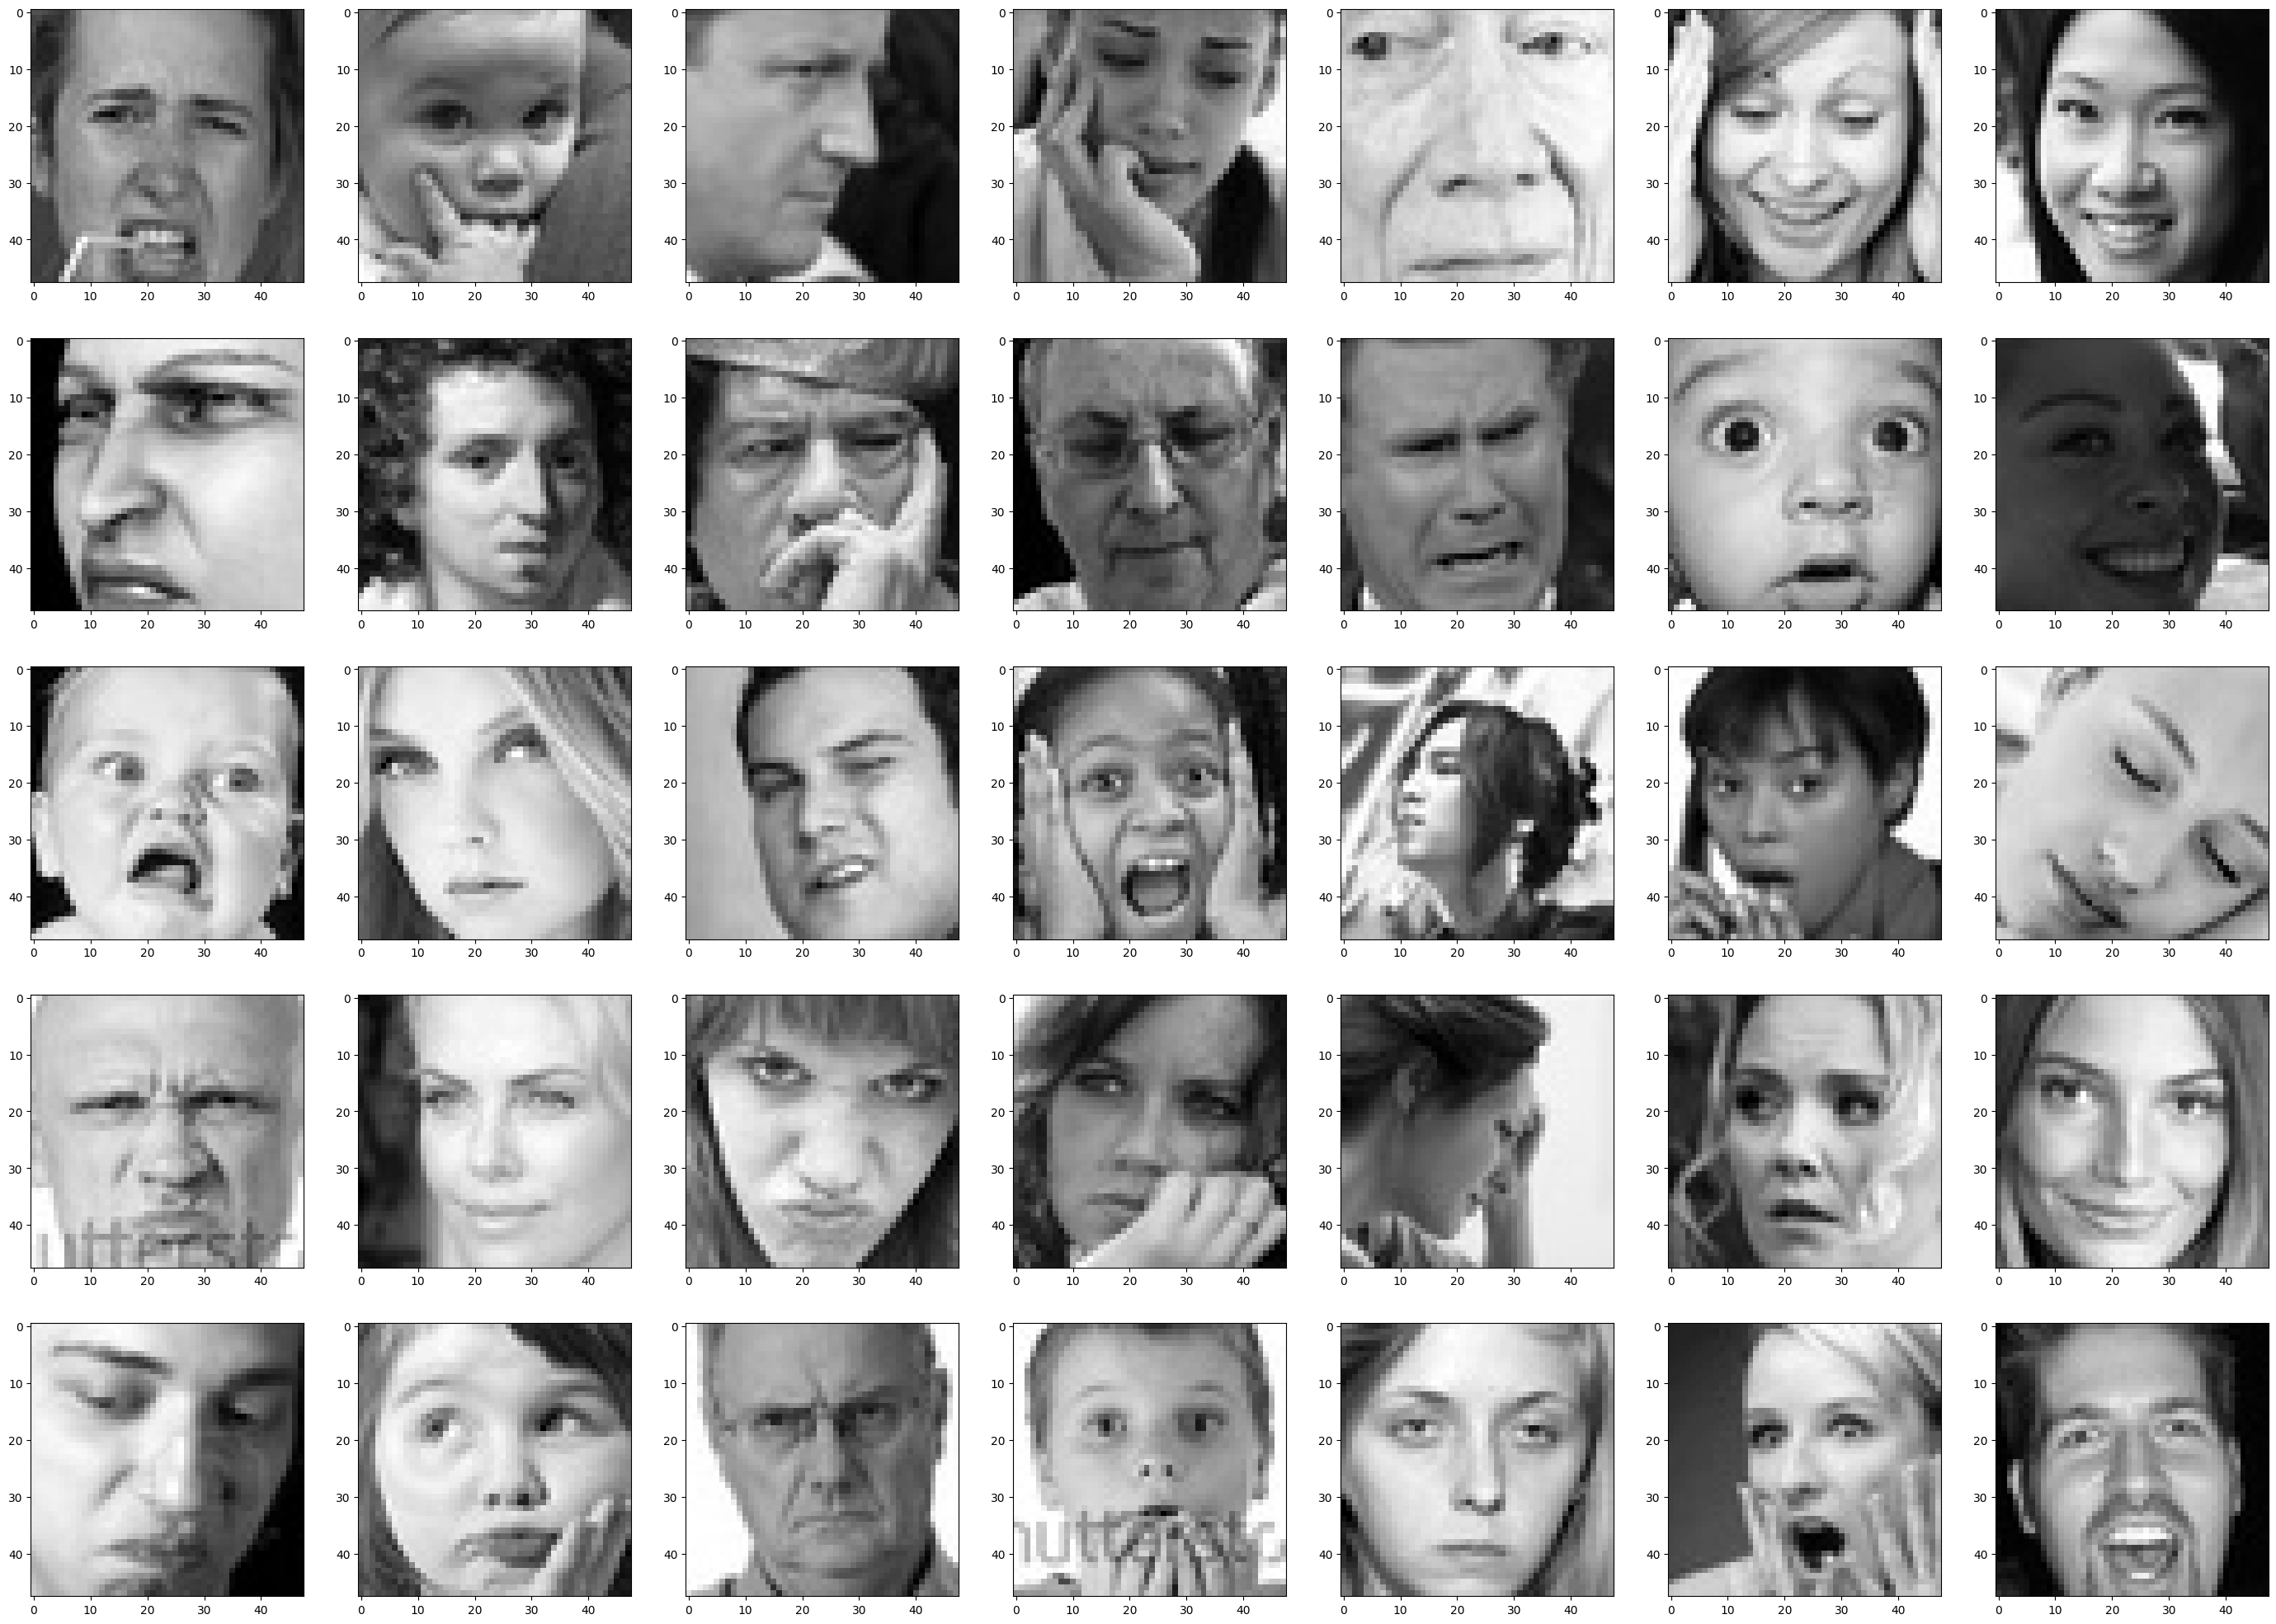

In [ ]:
# Data Visualization
from skimage.io import imread
train_dir = "/content/train/"
test_dir = "/content/test/"
total_labels = len(os.listdir(train_dir))

fig, ax = plt.subplots(nrows=5, ncols=total_labels, figsize=(35, 25))
for x in range(5):
    for y,v in zip(range(total_labels),os.listdir(train_dir)):
        ax[x][y].imshow(imread(train_dir+v+'/'+os.listdir(train_dir+v)[x]), cmap='gray')

plt.show()

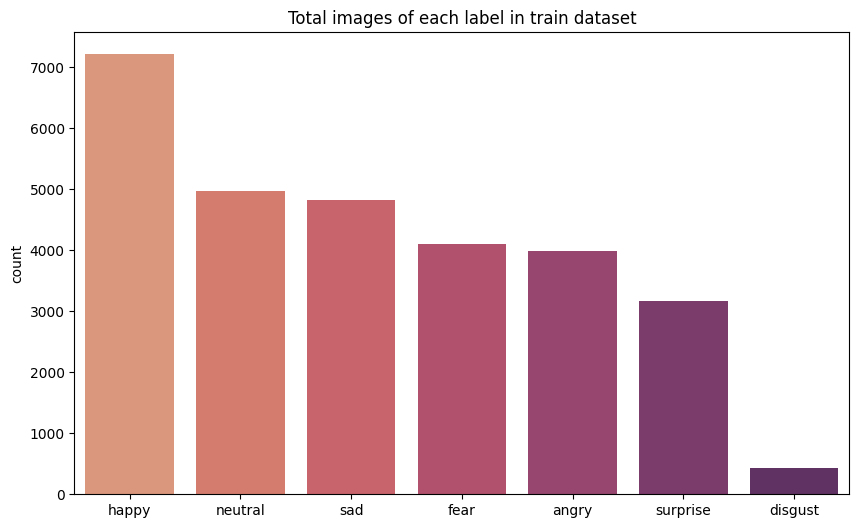

In [ ]:
df = {}
for i in os.listdir(train_dir):
    directory = train_dir + i
    df[i] = len(os.listdir(directory))
df = pd.DataFrame(df, index=["total"]).transpose().sort_values("total", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=df.index, y="total", palette="flare", data=df)
plt.ylabel("count")
plt.title("Total images of each label in train dataset")
plt.show()

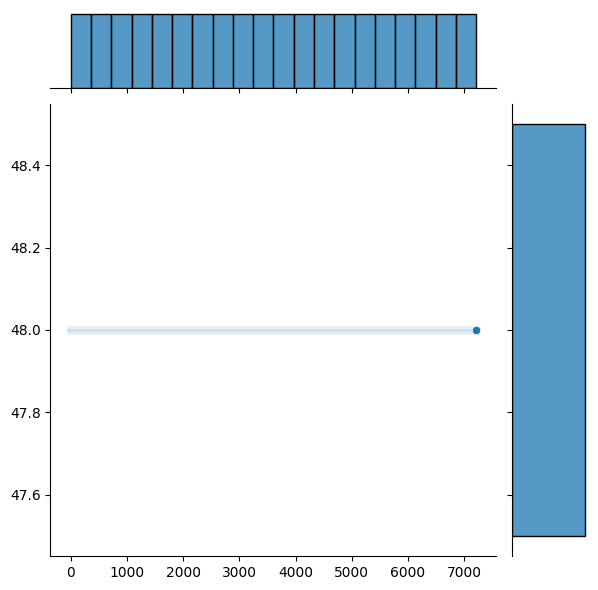

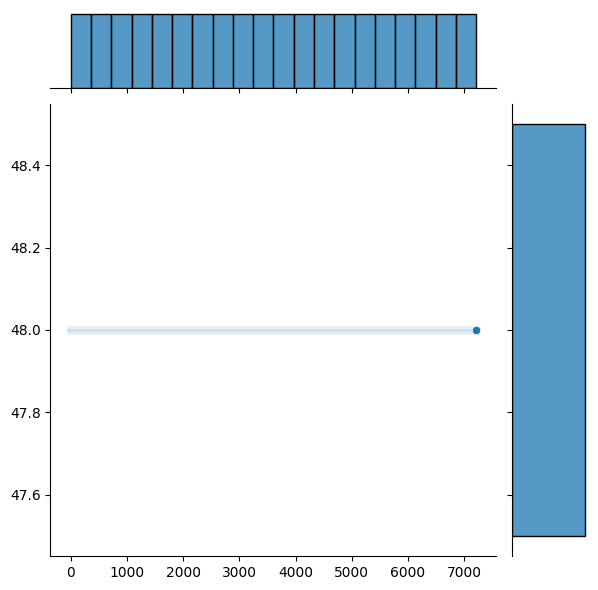

In [ ]:
happy = os.listdir(train_dir+'happy/')
dim1, dim2 = [], []

for img_filename in happy:
    img = imread(train_dir+'happy/'+img_filename)
    d1, d2 = img.shape
    dim1.append(d1)
    dim2.append(d2)

img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)
sns.jointplot(dim1 )
sns.jointplot(dim2 )
plt.show()

In [ ]:
# Data Preprocessing
train_gen = ImageDataGenerator(rescale=1/255,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest')

test_gen = ImageDataGenerator(rescale=1/255)

img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)

train_generator = train_gen.flow_from_directory(directory=train_dir,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=True)

test_generator = test_gen.flow_from_directory(directory=test_dir,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:

# Create the Model
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=img_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=len(os.listdir(train_dir)), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 128)      5

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = test_generator.n // test_generator.batch_size
num_epochs = 11

history = model.fit(train_generator,
                    epochs=num_epochs,
                    verbose=1,
                    #callbacks=callbacks,
                    validation_data=test_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

Epoch 1/11
448/448 [==============================] - 48s 76ms/step - loss: 1.8721 - accuracy: 0.2340 - val_loss: 2.7355 - val_accuracy: 0.2091
Epoch 2/11
448/448 [==============================] - 34s 75ms/step - loss: 1.8010 - accuracy: 0.2474 - val_loss: 1.8634 - val_accuracy: 0.2591
Epoch 3/11
448/448 [==============================] - 33s 74ms/step - loss: 1.7863 - accuracy: 0.2591 - val_loss: 1.7846 - val_accuracy: 0.2868
Epoch 4/11
448/448 [==============================] - 32s 70ms/step - loss: 1.7748 - accuracy: 0.2650 - val_loss: 1.7077 - val_accuracy: 0.3161
Epoch 5/11
448/448 [==============================] - 32s 72ms/step - loss: 1.7579 - accuracy: 0.2770 - val_loss: 1.7009 - val_accuracy: 0.3313
Epoch 6/11
448/448 [==============================] - 32s 71ms/step - loss: 1.7339 - accuracy: 0.2932 - val_loss: 1.6189 - val_accuracy: 0.3612
Epoch 7/11
448/448 [==============================] - 35s 78ms/step - loss: 1.7033 - accuracy: 0.3075 - val_loss: 1.6438 - val_accuracy:

In [ ]:
model.save("model.h5")

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print("validation accuracy :", str(test_acc*100)+"%")
print("validation loss :", test_loss)

113/113 [==============================] - 6s 49ms/step - loss: 1.4646 - accuracy: 0.4299
validation accuracy : 42.992475628852844%
validation loss : 1.4645569324493408


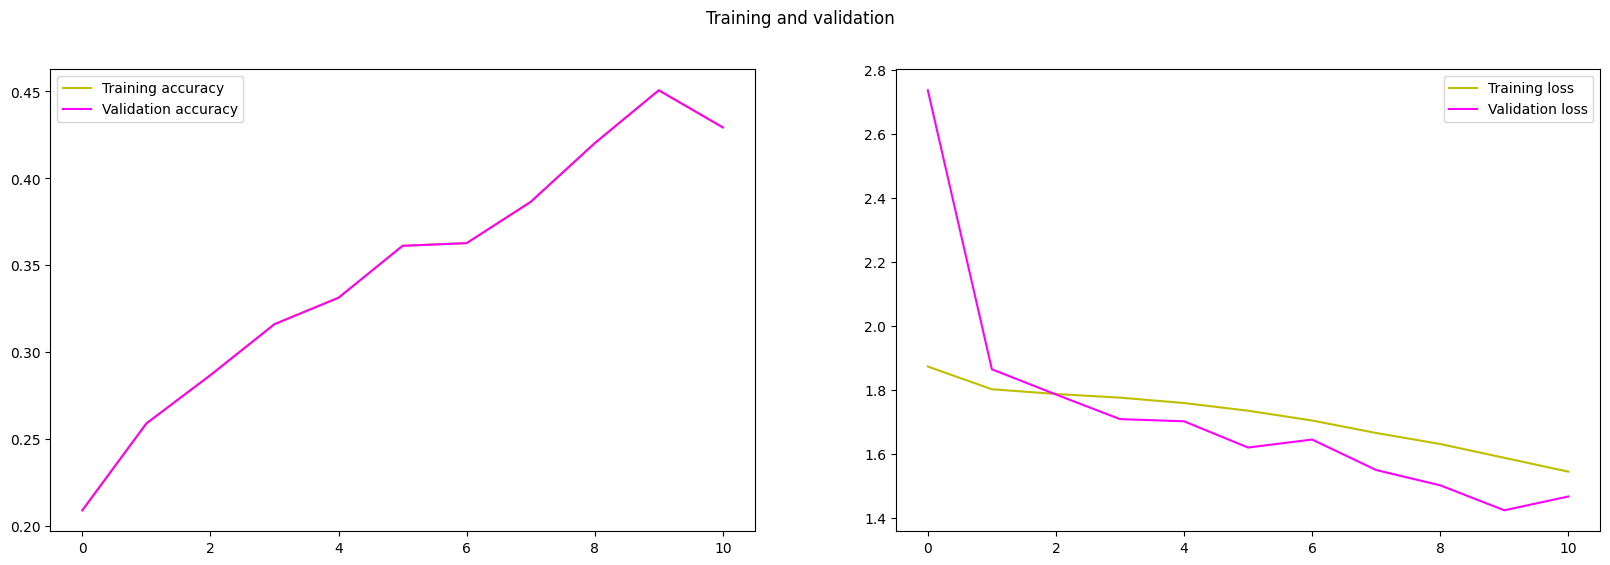

In [ ]:
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(val_acc))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].plot(epochs, val_acc, 'y', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'magenta', label='Validation accuracy')
ax[0].legend(loc=0)
ax[1].plot(epochs, loss, 'y', label='Training loss')
ax[1].plot(epochs, val_loss, 'magenta', label='Validation loss')
ax[1].legend(loc=0)

plt.suptitle('Training and validation')
plt.show()

113/113 [==============================] - 5s 39ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       angry       0.26      0.39      0.31       958
     disgust       0.00      0.00      0.00       111
        fear       0.26      0.23      0.25      1024
       happy       0.67      0.66      0.66      1774
     neutral       0.38      0.35      0.36      1233
         sad       0.33      0.25      0.28      1247
    surprise       0.58      0.67      0.62       831

    accuracy                           0.43      7178
   macro avg       0.35      0.37      0.36      7178
weighted avg       0.43      0.43      0.42      7178





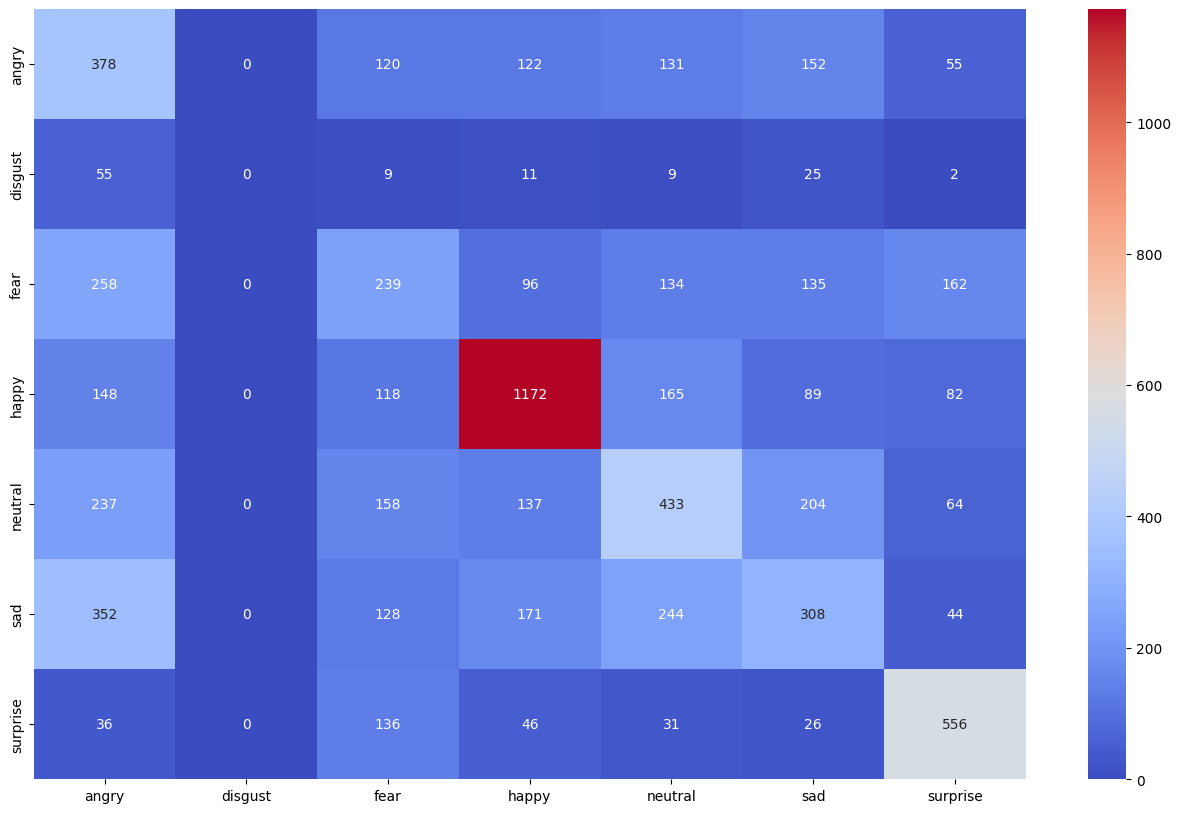

In [ ]:
# confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model.predict(test_generator), axis=-1)
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()), end='\n\n\n')

cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(16,10))
sns.heatmap(cm, cmap=plt.cm.coolwarm, annot=True, fmt='.0f', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.show()

In [ ]:
# Testing our model with new image
image = cv2.imread("images/téléchargement.jpg")
from IPython.display import Image
Image(filename="images/téléchargement.jpg")

In [ ]:
# Model Prediction
import cv2
from tensorflow.python.keras.models import load_model
import os


# # load the trained model
import tensorflow as tf

model_path = '/content/model.h5'  # Replace with the actual path to your model file
model = tf.keras.models.load_model(model_path)
# A list of emoticon categories
EMOTIONS = ['Angry', 'Disgust', 'Happy', 'Sad', 'Surprise', 'Neutral']
# Load image
img = image

# Trim the image to 48 x 48, and turn the grayscale image, normalization
frame = cv2.resize(img,(48,48),interpolation=cv2.INTER_BITS2)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 255.0

# Reinvent the image dimension
gray = gray.reshape(1,48,48,1)

# Output the prediction
predicts = model.predict(gray)[0]
label = EMOTIONS[predicts.argmax()]
for (i,j) in zip(range(7),EMOTIONS):
    predictss = predicts[i]
    print("{:^10s}".format(j)+"prediction rate is   {0:.2f}%".format(predictss))
print( "\n\n The system considers this expression to be:",label)

1/1 [==============================] - 1s 1s/step
  Angry   prediction rate is   0.24%
 Disgust  prediction rate is   0.01%
  Happy   prediction rate is   0.11%
   Sad    prediction rate is   0.37%
 Surprise prediction rate is   0.09%
 Neutral  prediction rate is   0.16%


 The system considers this expression to be: Sad


In [ ]:
# Song Recommdation
if (label=='Angry'):
    #path="test\\Angry\\"
    #files=os.listdir(path)
    #d=random.choice(files)
    #print("Now Playing:",d)
    audio = Audio(filename='/content/song/Angry/Changeable  Happy Sad  (East post-classical song).mp3'+ d,autoplay=True)
    display(audio)

elif (label=='Disgust'):
    path="test\\Disgust\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='song\\Disgust\\'+ d,autoplay=True)
    display(audio)

elif (label=="Happy"):
    #path="test\\happy\\"
    #files=os.listdir(path)
    #d=random.choice(files)
    print("Now Playing:")
    audio = Audio(filename='/content/song/Happy/HAPPY HAPPY HAPPY  TikTok sound effect.mp3'+ d,autoplay=True)
    display(audio)

elif label == 'Sad':
    path = "test/sad/"  # Update the path to your directory of sad songs
    #files = os.listdir('/content/song')
    #d = random.choice(files)
    print("Now Playing:")
    #audio_path = os.path.join(path, d)
    audio = Audio('/content/song/Sad/Sad Music Sound Effect.mp3', autoplay=True)
    display(audio)
elif (label=='Surprise'):
    path="test\\Surprise\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='song\\Surprise\\'+ d,autoplay=True)
    display(audio)

elif (label=='Neutral'):
    path="test\\Neutral\\"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='song\\Neutral\\'+ d,autoplay=True)
    display(audio)

Now Playing:


In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)

    # Convert the captured photo to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Perform face detection using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)

    # Draw face bounding box on the image
  for (x, y, w, h) in faces:
      img = cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Save the processed image
  cv2.imwrite(filename, img)

  return filename


In [ ]:
photo_filename = take_photo()

<IPython.core.display.Javascript object>

In [ ]:
img = cv2.imread(photo_filename)
frame = cv2.resize(img, (48, 48), interpolation=cv2.INTER_BITS2)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 255.0
gray = gray.reshape(1, 48, 48, 1)
predicts = model.predict(gray)[0]
label = EMOTIONS[predicts.argmax()]

# Output the prediction probabilities for each emotion
for (i, j) in zip(range(7), EMOTIONS):
    predictss = predicts[i]
    print("{:^10s}".format(j) + " prediction rate is   {0:.2f}%".format(predictss))

if label == 'Angry':
        audio = Audio(filename='/content/song/Angry/Changeable  Happy Sad  (East post-classical song).mp3', autoplay=True)
        display(audio)
elif label == 'Disgust':
        audio = Audio(filename='/content/song/Disgust/' + random.choice(os.listdir('/content/song/Disgust/')), autoplay=True)
        display(audio)
elif label == 'Happy':
        audio = Audio(filename='/content/song/Happy/HAPPY HAPPY HAPPY  TikTok sound effect.mp3', autoplay=True)
        display(audio)
elif label == 'Sad':
        audio = Audio(filename='/content/song/Sad/Sad Music Sound Effect.mp3', autoplay=True)
        display(audio)


print("\n\n The system considers this expression to be:", label)


In [ ]:
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# Start streaming video from webcam
video_stream()

# Label for video
label_html = 'Capturing...'

# Initialize bounding box to empty
bbox = ''
count = 0

while True:
    # Get frame from video stream
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # Convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # Create transparent overlay for bounding box
    bbox_array = np.zeros([480, 640, 4], dtype=np.uint8)

    # Grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Perform face detection
    faces = face_cascade.detectMultiScale(gray)

    # Get face bounding box for overlay
    for (x, y, w, h) in faces:
        bbox_array = cv2.rectangle(bbox_array, (x, y), (x+w, y+h), (255, 0, 0), 2)

    bbox_array[:, :, 3] = (bbox_array.max(axis=2) > 0).astype(int) * 255

    # Convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)

    # Update bbox so the next frame gets a new overlay
    bbox = bbox_bytes

    # Perform emotion prediction using your model and suggest a song based on the predicted label
    frame = cv2.resize(img, (48, 48), interpolation=cv2.INTER_BITS2)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 255.0
    gray = gray.reshape(1, 48, 48, 1)
    predicts = model.predict(gray)[0]
    label = EMOTIONS[predicts.argmax()]

    # Suggest a song based on the predicted emotion label
    #SuggestSong(label)
